## orfanage

In [36]:
import pandas as pd

# 读取 blastp.outfmt6 文件，假设文件以 tab 分隔且没有标题行
result_df = pd.read_csv('./result.outfmt6', sep='\t', header=None)

# 添加列名，标准BLAST格式为outfmt 6
result_df.columns = ['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen', 
                     'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bitscore']

# 确保 query 列的所有值都是字符串
result_df['query'] = result_df['query'].astype(str)

# 提取 query 列的最后一个 '.' 之前的内容
# result_df['query'] = result_df['query'].apply(lambda x: x.rsplit('.', 1)[0])

# 将 fident 列转换为浮点数，忽略非数值内容
result_df['fident'] = pd.to_numeric(result_df['fident'], errors='coerce')

# 过滤掉无法转换为浮点数的行
result_df = result_df.dropna(subset=['fident'])

# 按 query 和 fident 排序，保留 fident 最高的行
filtered_result_df = result_df.sort_values('fident', ascending=False).drop_duplicates('query', keep='first')

# 读取 brca_1miCount_1miDatasets_filtered.gff3_classification.txt 文件
gff3_df = pd.read_csv('../../../brca_1miCount_1miDatasets_filtered.gff3_classification.txt', sep='\t')

# 确保 isoform 列唯一，以防止意外重复
gff3_df = gff3_df.drop_duplicates(subset=['isoform'])

# 按 query 和 isoform 列进行左右合并，以 result_df 为主
merged_df = filtered_result_df.merge(gff3_df[['isoform', 'structural_category', 'predicted_NMD']], 
                                     left_on='query', right_on='isoform', how='left')

# 只保留需要的列
final_df = merged_df[['query', 'target', 'fident', 'gapopen','evalue', 'structural_category', 'predicted_NMD']]

# 保存合并后的结果到新文件，并添加列名
final_df.to_csv('merged_orfanage.outfmt6', sep='\t', index=False, 
                header=['query', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD'])

print("Merged results saved to merged_results.outfmt6")


/master/jiang_tao/0.software/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Merged results saved to merged_results.outfmt6


In [37]:
import pandas as pd

# 读取文件
df = pd.read_csv('./merged_orfanage.outfmt6', sep='\t')

# 提取structural_category为'full-splice_match'的行
filtered_df = df[df['structural_category'] == 'full-splice_match']

# # 计算fident >= 0.9的行数和fident < 0.99的行数
# fident_ge_099 = filtered_df[filtered_df['fident'] >= 90].shape[0]
# fident_lt_099 = filtered_df[filtered_df['fident'] < 90].shape[0]

# 计算fident >= 0.99的行数和fident < 0.99的行数
fident_ge_099 = filtered_df[filtered_df['fident'] >= .99].shape[0]
fident_lt_099 = filtered_df[filtered_df['fident'] < .99].shape[0]

# 计算比率
total = fident_ge_099 + fident_lt_099
ratio_ge_099 = fident_ge_099 / total if total > 0 else 0
ratio_lt_099 = fident_lt_099 / total if total > 0 else 0

# 输出结果
print(f"fident >= 99: {fident_ge_099}, fident < 99: {fident_lt_099}")
print(f"Ratio of fident >= 0.99: {ratio_ge_099:.2f}, fident < 0.99: {ratio_lt_099:.2f}")


fident >= 99: 8810, fident < 99: 12923
Ratio of fident >= 0.99: 0.41, fident < 0.99: 0.59


/tmp/ipykernel_1287118/3088531900.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Selected structural category distribution plot saved as selected_structural_category_distribution.png


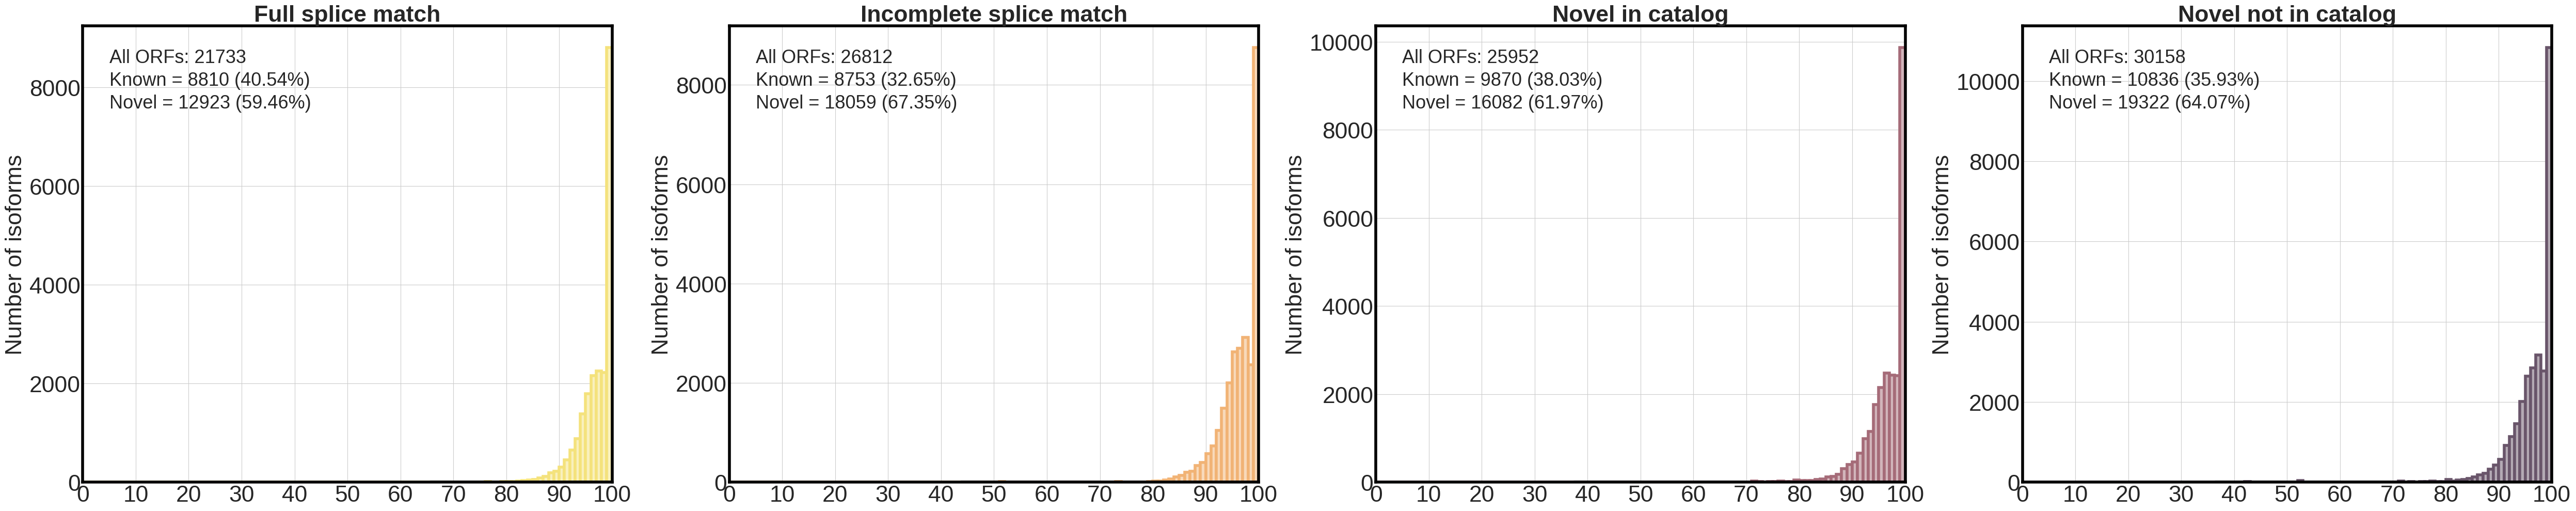

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# 读取 merged_results.outfmt6 文件
df = pd.read_csv('./merged_orfanage.outfmt6', sep='\t')

# 定义函数来格式化 structural_category
def format_category(category):
    words = re.split('_|-', category)
    words[0] = words[0].capitalize()
    return ' '.join(words)

# 应用格式化函数
df['structural_category'] = df['structural_category'].apply(format_category)
df['fident']=df['fident']*100
# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 定义要绘制的类别和对应的颜色
categories_to_plot = [
    'Full splice match',
    'Incomplete splice match',
    'Novel in catalog',
    'Novel not in catalog'
]

# 定义浅色和深色
dark_colors = ['#F4E27C', '#f1b375', '#a56b78','#69556a']  # 深蓝、深橙、深绿、深红
light_colors = ['#f9f0bd', '#f8d9ba', '#d2b5bb', '#b4aab4']  # 浅蓝、浅橙、浅绿、浅红

# 创建1x4的子图
fig, axs = plt.subplots(1, 4, figsize=(50, 10), squeeze=False)

# 定义 bin 的范围
bins = np.arange(0, 101, 1)  # 0到100，步长为1

# 遍历选定的 structural categories
for i, category in enumerate(categories_to_plot):
    # 获取该类别的数据
    cat_data = df[df['structural_category'] == category]
   
    # 计算统计数据
    total_queries = len(cat_data)
    known_queries = len(cat_data[cat_data['fident'] >= 99])
    novel_queries = total_queries - known_queries
    known_percent = (known_queries / total_queries) * 100
    novel_percent = (novel_queries / total_queries) * 100
   
    # 创建直方图数据
    hist, _ = np.histogram(cat_data['fident'], bins=bins)
   
    # 绘制条形图
    axs[0, i].bar(bins[:-1], hist, width=1, color=light_colors[i],
                  edgecolor=dark_colors[i], align='edge', linewidth=4)
   
    # 在条形图上叠加一层密度曲线
    sns.kdeplot(data=cat_data['fident'], ax=axs[0, i],
                color='black', linewidth=4,
                cut=0, clip=(0, 100))
   
    # 设置标题和标签
    axs[0, i].set_title(f'{category}', fontsize=32, fontweight='bold')
    axs[0, i].set_xlabel('', fontsize=32)
    axs[0, i].set_ylabel('Number of isoforms', fontsize=32)
   
    # 设置x轴范围和刻度
    axs[0, i].set_xlim(0, 100)
    axs[0, i].set_xticks(range(0, 101, 10))
   
    # 调整刻度标签大小
    axs[0, i].tick_params(axis='both', which='major', labelsize=32)
   
    # 添加黑色边框
    for spine in axs[0, i].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(4)
   
    # 添加标签
    axs[0, i].text(0.05, 0.95, f'All ORFs: {total_queries}', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.90, f'Known = {known_queries} ({known_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.85, f'Novel = {novel_queries} ({novel_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')

# 调整子图之间的间距
plt.tight_layout()

# 保存图表
# plt.savefig('selected_structural_category_distribution.png', dpi=500, bbox_inches='tight')
print("Selected structural category distribution plot saved as selected_structural_category_distribution.png")

# 显示图表(如果您在支持图形界面的环境中运行)
# plt.show()

## Blast的结构作为对比测试

In [47]:
import pandas as pd

# 打开文件并提取完整的 ORF IDs 列表
with open('../../../transcripts_brca_1miC_1miS.fa.transdecoder.pep', 'r') as file:
    complete_orf_ids = []
    for line in file:
        if line.startswith('>') and 'ORF type:complete' in line:
            fasta_id = line.split()[0][1:]  # 去掉 ">" 并提取 ID 部分
            complete_orf_ids.append(fasta_id)

# 检查是否成功提取 ORF IDs
if not complete_orf_ids:
    print("Error: No complete ORF IDs were found.")
    exit()

# 读取 result2.outfmt6 文件
try:
    result_df = pd.read_csv('./result2.outfmt6', sep='\t', header=None)
except FileNotFoundError:
    print("Error: result2.outfmt6 file not found.")
    exit()

# 添加列名，标准BLAST格式为outfmt 6
result_df.columns = ['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen', 
                     'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bitscore']

# 确保 query 列的所有值都是字符串
result_df['query'] = result_df['query'].astype(str)
# 过滤出 query 在 complete_orf_ids 列表中的行
filtered_result_df = result_df[result_df['query'].isin(complete_orf_ids)]
# 提取 query 列的最后一个 '.' 之前的内容
filtered_result_df ['query'] = filtered_result_df ['query'].apply(lambda x: x.rsplit('.', 1)[0])



# 将 fident 列转换为浮点数，忽略非数值内容
filtered_result_df['fident'] = pd.to_numeric(filtered_result_df['fident'], errors='coerce')

# 过滤掉无法转换为浮点数的行
filtered_result_df = filtered_result_df.dropna(subset=['fident'])

# 按 query 和 fident 排序，保留 fident 最高的行
filtered_result_df = filtered_result_df.sort_values('fident', ascending=False).drop_duplicates('query', keep='first')

# 读取 PacBio 分类文件
try:
    gff3_df = pd.read_csv('../../../brca_1miCount_1miDatasets_filtered.gff3_classification.txt', sep='\t')
except FileNotFoundError:
    print("Error: PacBio classification file not found.")
    exit()

# 确保 isoform 列唯一，以防止意外重复
gff3_df = gff3_df.drop_duplicates(subset=['isoform'])

# 按 query 和 isoform 列进行左右合并，以 filtered_result_df 为主
merged_df = filtered_result_df.merge(gff3_df[['isoform', 'structural_category', 'predicted_NMD']], 
                                     left_on='query', right_on='isoform', how='left')

# 只保留需要的列
final_df = merged_df[['query', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD']]

# 打印结果
print(final_df)

# 保存合并后的结果到新文件，并添加列名
output_file = 'merged_result.outfmt6'
final_df.to_csv(output_file, sep='\t', index=False, 
                header=['query', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD'])

print(f"Merged results saved to {output_file}")


/master/jiang_tao/0.software/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_1287118/4129319193.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result_df ['query'] = filtered_result_df ['query'].apply(lambda x: x.rsplit('.', 1)[0])
/tmp/ipykernel_1287118/4129319193.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

                    query      target  fident gapopen evalue  \
0         TALONT000338480  A0A7P0NGZ6   1.000       0    0.0   
1         TALONT000339691      K9IM55   1.000       0    0.0   
2         TALONT000410977      H2QJK2   1.000       0    0.0   
3         TALONT000407006      C9IYM5   1.000       0    0.0   
4         TALONT000394896      H2RCG0   1.000       0    0.0   
...                   ...         ...     ...     ...    ...   
87769     TALONT000276509  A0A417M867   0.242       0    0.0   
87770     TALONT000276495  A0A417M867   0.242       0    0.0   
87771     TALONT000276478  A0A417M867   0.242       0    0.0   
87772     TALONT000276500  A0A417M867   0.242       0    0.0   
87773  ENST00000355480.10  A0A417M867   0.242       0    0.0   

           structural_category predicted_NMD  
0         novel_not_in_catalog          True  
1         novel_not_in_catalog          True  
2             novel_in_catalog         False  
3             novel_in_catalog           Na

In [48]:
import pandas as pd

# 读取文件
df = pd.read_csv('merged_result.outfmt6', sep='\t')

# 提取structural_category为'full-splice_match'且predicted_NMD为False的行
filtered_df = df[(df['structural_category'] == 'full-splice_match') & (df['predicted_NMD'] == False)]

# 计算fident >= 0.99的行数和fident < 0.99的行数
fident_ge_099 = filtered_df[filtered_df['fident'] >= 0.99].shape[0]
fident_lt_099 = filtered_df[filtered_df['fident'] < 0.99].shape[0]

# 计算比率
total = fident_ge_099 + fident_lt_099
ratio_ge_099 = fident_ge_099 / total if total > 0 else 0
ratio_lt_099 = fident_lt_099 / total if total > 0 else 0

# 输出结果
print(f"fident >= 0.99: {fident_ge_099}, fident < 0.99: {fident_lt_099}")
print(f"Ratio of fident >= 0.99: {ratio_ge_099:.2f}, fident < 0.99: {ratio_lt_099:.2f}")


fident >= 0.99: 7574, fident < 0.99: 9091
Ratio of fident >= 0.99: 0.45, fident < 0.99: 0.55


/tmp/ipykernel_1287118/231214086.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Selected structural category distribution plot saved as selected_structural_category_distribution.png


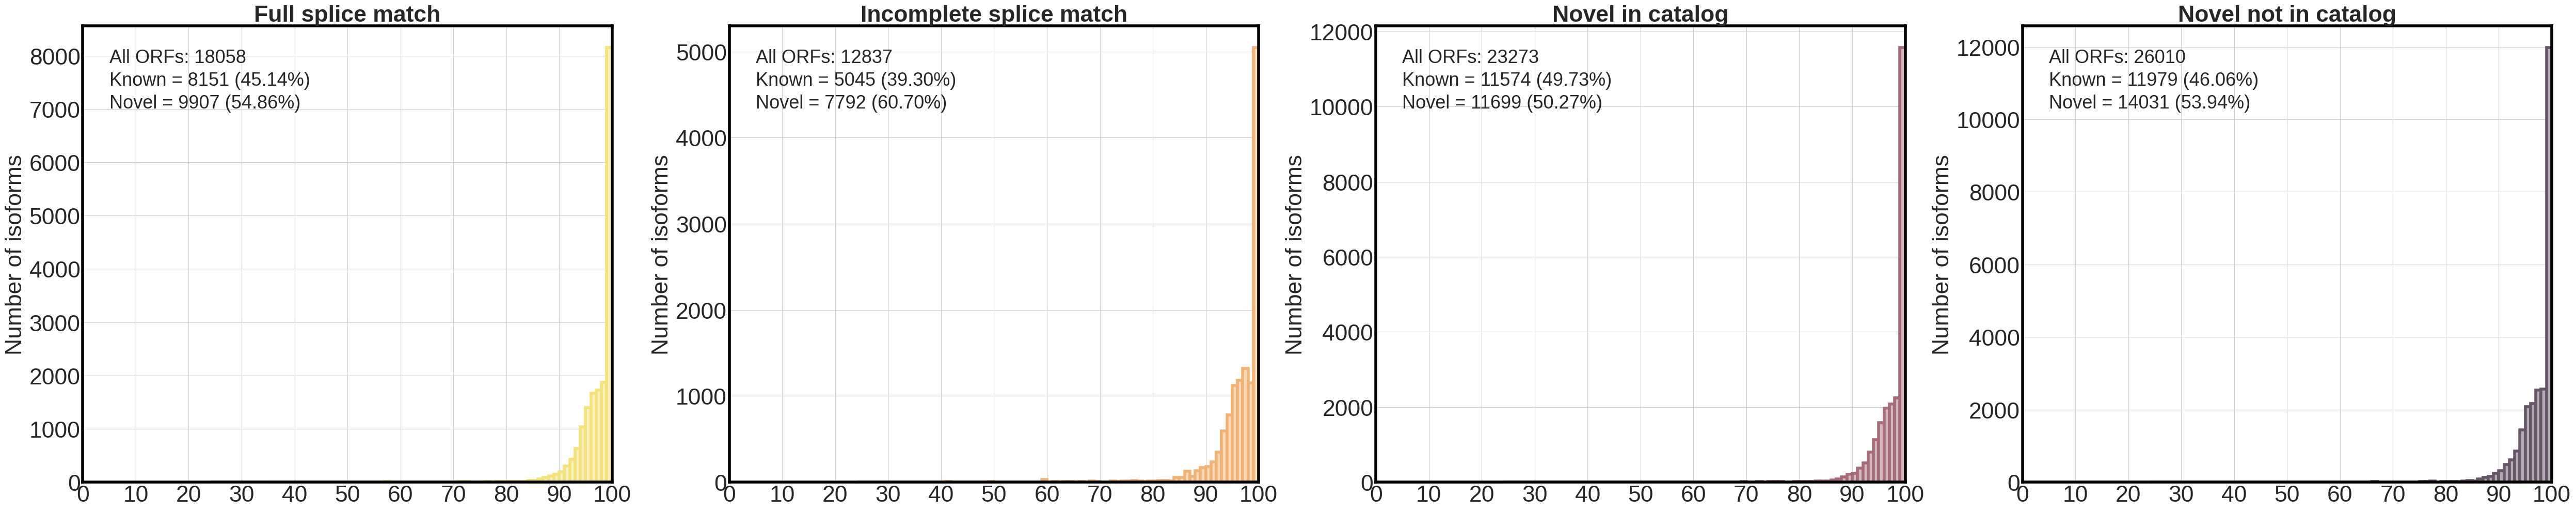

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# 读取 merged_results.outfmt6 文件
df = pd.read_csv('merged_result.outfmt6', sep='\t')

# 定义函数来格式化 structural_category
def format_category(category):
    words = re.split('_|-', category)
    words[0] = words[0].capitalize()
    return ' '.join(words)

# 应用格式化函数
df['structural_category'] = df['structural_category'].apply(format_category)
df['fident']=df['fident']*100
# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 定义要绘制的类别和对应的颜色
categories_to_plot = [
    'Full splice match',
    'Incomplete splice match',
    'Novel in catalog',
    'Novel not in catalog'
]

# 定义浅色和深色
dark_colors = ['#F4E27C', '#f1b375', '#a56b78','#69556a']  # 深蓝、深橙、深绿、深红
light_colors = ['#f9f0bd', '#f8d9ba', '#d2b5bb', '#b4aab4']  # 浅蓝、浅橙、浅绿、浅红

# 创建1x4的子图
fig, axs = plt.subplots(1, 4, figsize=(50, 10), squeeze=False)

# 定义 bin 的范围
bins = np.arange(0, 101, 1)  # 0到100，步长为1

# 遍历选定的 structural categories
for i, category in enumerate(categories_to_plot):
    # 获取该类别的数据
    cat_data = df[df['structural_category'] == category]
   
    # 计算统计数据
    total_queries = len(cat_data)
    known_queries = len(cat_data[cat_data['fident'] >= 99])
    novel_queries = total_queries - known_queries
    known_percent = (known_queries / total_queries) * 100
    novel_percent = (novel_queries / total_queries) * 100
   
    # 创建直方图数据
    hist, _ = np.histogram(cat_data['fident'], bins=bins)
   
    # 绘制条形图
    axs[0, i].bar(bins[:-1], hist, width=1, color=light_colors[i],
                  edgecolor=dark_colors[i], align='edge', linewidth=4)
   
    # 在条形图上叠加一层密度曲线
    sns.kdeplot(data=cat_data['fident'], ax=axs[0, i],
                color='black', linewidth=4,
                cut=0, clip=(0, 100))
   
    # 设置标题和标签
    axs[0, i].set_title(f'{category}', fontsize=32, fontweight='bold')
    axs[0, i].set_xlabel('', fontsize=32)
    axs[0, i].set_ylabel('Number of isoforms', fontsize=32)
   
    # 设置x轴范围和刻度
    axs[0, i].set_xlim(0, 100)
    axs[0, i].set_xticks(range(0, 101, 10))
   
    # 调整刻度标签大小
    axs[0, i].tick_params(axis='both', which='major', labelsize=32)
   
    # 添加黑色边框
    for spine in axs[0, i].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(4)
   
    # 添加标签
    axs[0, i].text(0.05, 0.95, f'All ORFs: {total_queries}', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.90, f'Known = {known_queries} ({known_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.85, f'Novel = {novel_queries} ({novel_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')

# 调整子图之间的间距
plt.tight_layout()

# 保存图表
plt.savefig('selected_structural_category_distribution.png', dpi=500, bbox_inches='tight')
print("Selected structural category distribution plot saved as selected_structural_category_distribution.png")

# 显示图表(如果您在支持图形界面的环境中运行)
# plt.show()

## 不要NMD

/tmp/ipykernel_1287118/1213884810.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Selected structural category distribution plot saved as SVG and PDF.


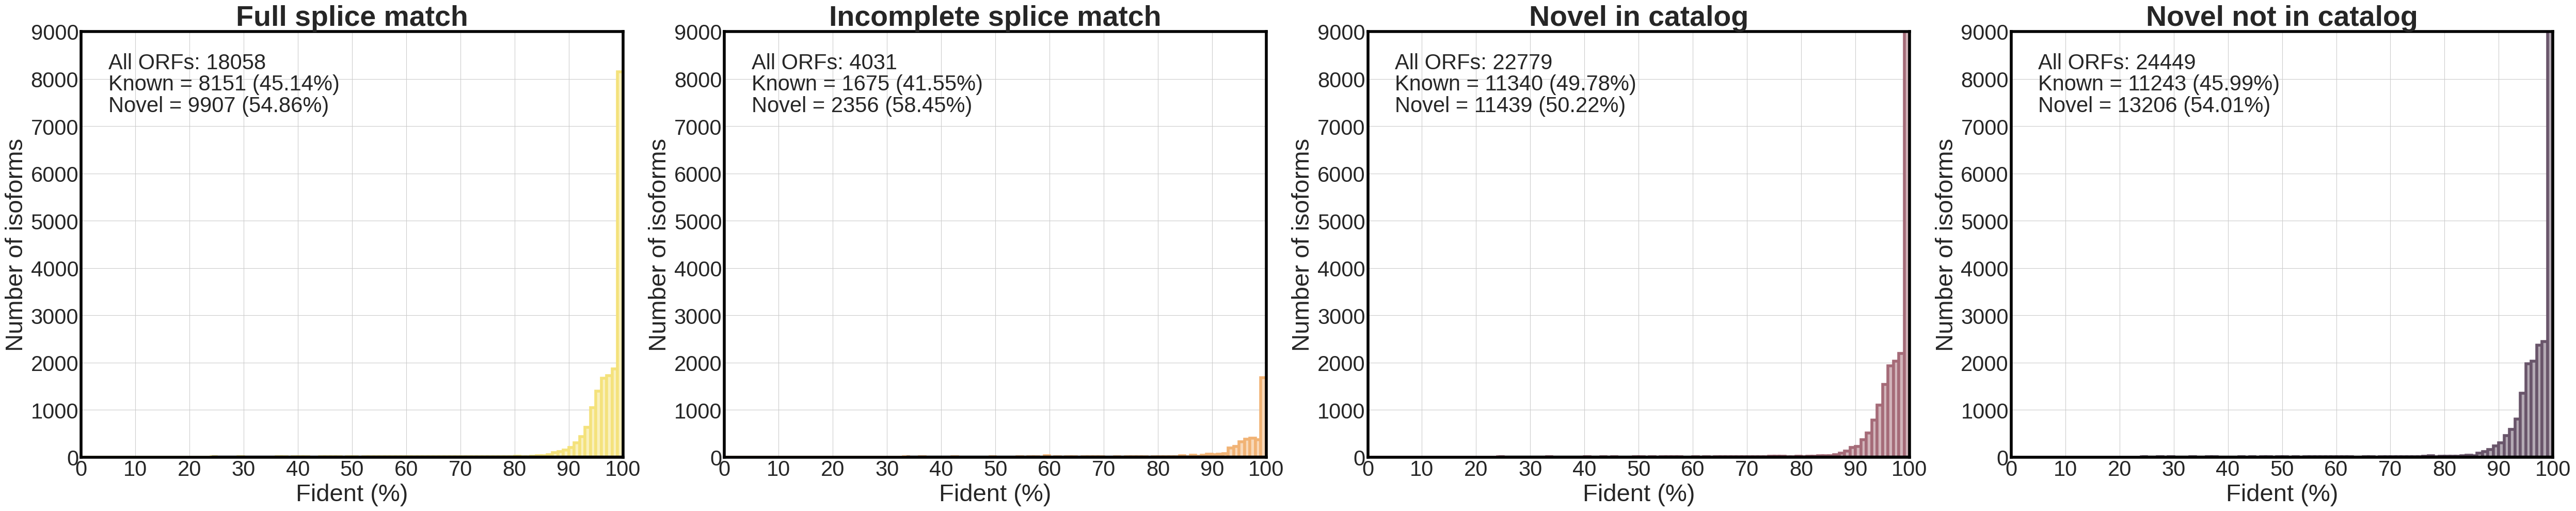

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# 读取 merged_results.outfmt6 文件
df = pd.read_csv('./filtering_transcriptome/merged_result.outfmt6', sep='\t')

# 修改 format_category 函数，检查是否为字符串并处理空值
def format_category(category):
    if pd.isna(category) or not isinstance(category, str):
        return category  # 如果是空值或非字符串，直接返回
    words = re.split('_|-', category)
    words[0] = words[0].capitalize()
    return ' '.join(words)

# 应用格式化函数
df['structural_category'] = df['structural_category'].apply(format_category)

df['fident'] = df['fident'] * 100  # 将fident从0-1范围转换为0-100

# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 定义要绘制的类别和对应的颜色
categories_to_plot = [
    'Full splice match',
    'Incomplete splice match',
    'Novel in catalog',
    'Novel not in catalog'
]

# 定义浅色和深色
dark_colors = ['#F4E27C', '#f1b375', '#a56b78', '#69556a']  # 深色
light_colors = ['#f9f0bd', '#f8d9ba', '#d2b5bb', '#b4aab4']  # 浅色

# 创建1x4的子图
fig, axs = plt.subplots(1, 4, figsize=(50, 10), squeeze=False)

# 定义 bin 的范围
bins = np.arange(0, 101, 1)  # 0到100，步长为1

# 遍历选定的 structural categories
for i, category in enumerate(categories_to_plot):
    # 获取该类别的数据
    cat_data = df[df['structural_category'] == category]
   
    # 计算统计数据
    total_queries = len(cat_data)
    known_queries = len(cat_data[cat_data['fident'] >= 99])
    novel_queries = total_queries - known_queries
    known_percent = (known_queries / total_queries) * 100 if total_queries > 0 else 0
    novel_percent = (novel_queries / total_queries) * 100 if total_queries > 0 else 0
   
    # 创建直方图数据
    hist, _ = np.histogram(cat_data['fident'], bins=bins)
   
    # 绘制条形图
    axs[0, i].bar(bins[:-1], hist, width=1, color=light_colors[i],
                  edgecolor=dark_colors[i], align='edge', linewidth=4)
   
    # 在条形图上叠加一层密度曲线
    sns.kdeplot(data=cat_data['fident'], ax=axs[0, i],
                color='black', linewidth=4,
                cut=0, clip=(0, 100))
   
    # 设置标题和标签，增大字体
    axs[0, i].set_title(f'{category}', fontsize=40, fontweight='bold')
    axs[0, i].set_xlabel('Fident (%)', fontsize=34)
    axs[0, i].set_ylabel('Number of isoforms', fontsize=34)
   
    # 设置x轴和y轴范围及刻度
    axs[0, i].set_xlim(0, 100)
    axs[0, i].set_ylim(0, 9000)  # 设置统一的 y 轴范围
    axs[0, i].set_xticks(range(0, 101, 10))
    axs[0, i].set_yticks(range(0, 9001, 1000))  # 设置 y 轴刻度为 1000 间隔
   
    # 调整刻度标签大小
    axs[0, i].tick_params(axis='both', which='major', labelsize=30)
   
    # 添加黑色边框
    for spine in axs[0, i].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(4)
   
    # 添加标签，增大字体
    axs[0, i].text(0.05, 0.95, f'All ORFs: {total_queries}', transform=axs[0, i].transAxes, fontsize=30, va='top')
    axs[0, i].text(0.05, 0.90, f'Known = {known_queries} ({known_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=30, va='top')
    axs[0, i].text(0.05, 0.85, f'Novel = {novel_queries} ({novel_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=30, va='top')

# 调整子图之间的间距
plt.tight_layout()

# 保存图表为 SVG 和 PDF 格式
plt.savefig('./filtering_transcriptome/selected_structural_category_distribution.svg', format='svg', dpi=500, bbox_inches='tight')
plt.savefig('./filtering_transcriptome/selected_structural_category_distribution.pdf', format='pdf', dpi=500, bbox_inches='tight')

print("Selected structural category distribution plot saved as SVG and PDF.")


# key ! 重设过滤条件

In [ ]:
import pandas as pd
import numpy as np

def filter_sqanti_results(input_file, output_file):
    # 读取SQANTI输出文件
    df = pd.read_csv(input_file, sep='\t')

    # 分离isoform_id以AF-开头的行，处理NaN值
    af_rows = df[df['isoform_id'].fillna('').str.startswith('AF-')]
    
    # 打印过滤前每个structural_category的数量，排除AF-开头的行
    print("Original structural_category counts (excluding AF-isoforms):")
    print(df[~df['isoform_id'].fillna('').str.startswith('AF-')]['structural_category'].value_counts())

    # 定义过滤函数
    def apply_filters(row):
        # 基本过滤条件：RTS_stage必须为False
        basic_filter = (row['RTS_stage'] == False)
        
        # 判断是否为canonical splice sites
        canonical = (row['all_canonical'] == 'canonical')
        
        # 读取覆盖度过滤：min_cov必须大于等于5
        coverage_filter = (row['min_cov'] >= 5)
        
        # detection rate
        detection = (row['sample_no'] >= 3)
        
        # NMD detection
        predicted_NMD = row['predicted_NMD'] == False
        
        # 3'末端可靠性过滤：满足3个条件之一
        three_prime_filter = (
            (abs(row['diff_to_TTS']) <= 100) or
            (row['within_polyA_site'] == True)
        )
        
        # 根据structural_category应用不同的过滤条件
        if row['structural_category'] == 'full-splice_match':
            # 对于 full-splice_match 不进行过滤，直接保留
            return True
        elif row['structural_category'] in ['novel_not_in_catalog']:
            return basic_filter
        elif row['structural_category'] in ['novel_in_catalog']:
            return basic_filter
        elif row['structural_category'] in ['incomplete-splice_match']:
            return basic_filter and three_prime_filter and detection and canonical and coverage_filter
        else:  # 其他类别 (genic, antisense, fusion, intergenic)
            return basic_filter and three_prime_filter and detection and canonical and coverage_filter
    
    # 对除isoform_id以AF-开头的行之外的所有行应用过滤条件
    df_filtered = df[~df['isoform_id'].fillna('').str.startswith('AF-')].copy()
    df_filtered = df_filtered[df_filtered.apply(apply_filters, axis=1)]

    # 合并保留的AF-开头的行和过滤后的其他行
    final_df = pd.concat([af_rows, df_filtered])

    # 保存过滤后的结果
    final_df.to_csv(output_file, sep='\t', index=False)

    # 打印过滤后的每个structural_category的数量，排除AF-开头的行
    print("\nFiltered structural_category counts (excluding AF-isoforms):")
    print(final_df[~final_df['isoform_id'].fillna('').str.startswith('AF-')]['structural_category'].value_counts())

    # 打印结果统计
    print(f"\nOriginal isoforms (excluding AF-isoforms): {len(df[~df['isoform_id'].fillna('').str.startswith('AF-')])}")
    print(f"Filtered isoforms (excluding AF-isoforms): {len(final_df[~final_df['isoform_id'].fillna('').str.startswith('AF-')])}")
    print(f"Percentage retained (excluding AF-isoforms): {len(final_df[~final_df['isoform_id'].fillna('').str.startswith('AF-')]) / len(df[~df['isoform_id'].fillna('').str.startswith('AF-')]) * 100:.2f}%")

# 使用示例
filter_sqanti_results('./020.brca_classifcation_sampeCount_loc_symbol_meanPSI_DR_deltaPSI_mane_drug_target_drug_FC_org_func_singleton.tsv', './filtering_transcriptome/021.filtered_0916_gff3_classification_merged_detection_rate.tsv')


/tmp/ipykernel_1287118/772190528.py:68: DtypeWarning: Columns (1,2,5,6,7,14,15,16,19,24,28,29,36,38,40,42,43,45,46,50,51,52,53,54,55,57,58,63,65,66,73) have mixed types.Specify dtype option on import or set low_memory=False.
  filter_sqanti_results('./020.brca_classifcation_sampeCount_loc_symbol_meanPSI_DR_deltaPSI_mane_drug_target_drug_FC_org_func_singleton.tsv', './filtering_transcriptome/021.filtered_0916_gff3_classification_merged_detection_rate.tsv')


Original structural_category counts (excluding AF-isoforms):
novel_not_in_catalog       32456
incomplete-splice_match    31494
novel_in_catalog           27272
full-splice_match          24176
intergenic                 10089
fusion                      2252
antisense                   1507
genic                         88
genic_intron                   1
Name: structural_category, dtype: int64

Filtered structural_category counts (excluding AF-isoforms):
novel_not_in_catalog       30467
novel_in_catalog           26697
full-splice_match          24176
incomplete-splice_match     9524
fusion                        53
antisense                      7
genic                          3
intergenic                     2
Name: structural_category, dtype: int64

Original isoforms (excluding AF-isoforms): 129337
Filtered isoforms (excluding AF-isoforms): 90929
Percentage retained (excluding AF-isoforms): 70.30%


## 提取一个sqanti3注释版本90928的用于某些情况的分析

In [1]:
import pandas as pd

# 文件路径
input_file = './filtering_transcriptome/021.filtered_0916_gff3_classification_merged_detection_rate.tsv'
output_file = './filtering_transcriptome/021.filtered_no_AFDB_sqanti3_classifcation_90928.tsv'

# 读取文件
df = pd.read_csv(input_file, sep='\t')

# 筛选第一列不以 AF- 开头的行
filtered_df = df[~df.iloc[:, 0].str.startswith('AF-')]

# 保存结果为新文件
filtered_df.to_csv(output_file, sep='\t', index=False)

print(f"过滤完成，结果已保存到 {output_file}")


/master/jiang_tao/0.software/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (1,2,5,6,7,14,15,16,19,24,28,29,36,38,40,42,43,45,46,50,51,52,53,54,55,57,58,63,66,73) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


过滤完成，结果已保存到 ./filtering_transcriptome/021.filtered_no_AFDB_sqanti3_classifcation_90928.tsv


 rename gene symbol (according to 3nd rename criteria)

In [4]:
import pandas as pd

# 文件路径
file_path = "/cpu2/jiang_tao/13.3Disoform/14_3DisoGalaxy_reinvent_20241217/01_transcriptome_QC/filtering_transcriptome/021.filtered_no_AFDB_sqanti3_classifcation_90928.tsv"
output_path = "/cpu2/jiang_tao/13.3Disoform/14_3DisoGalaxy_reinvent_20241217/01_transcriptome_QC/filtering_transcriptome/021.filtered_no_AFDB_sqanti3_classifcation_90928_renameSymbol.tsv"

# 读取数据
df = pd.read_csv(file_path, sep="\t")

# 初始化新列
df['gene_symbol_rename'] = df['associated_gene']

def process_group(group):
    wt_count = 0
    talont_count = 0

    for i, row in group.iterrows():
        node = row['isoform_id']
        gene_symbol = row['associated_gene']

        if node.startswith("ENST"):
            if wt_count == 0:
                group.at[i, 'gene_symbol_rename'] = f"{gene_symbol}_WT"
            else:
                group.at[i, 'gene_symbol_rename'] = f"{gene_symbol}_WT{wt_count}"
            wt_count += 1

        elif node.startswith("AF-"):
            group.at[i, 'gene_symbol_rename'] = f"HP_{gene_symbol}"

        elif node.startswith("TALONT"):
            if talont_count == 0:
                group.at[i, 'gene_symbol_rename'] = f"{gene_symbol}_un1"
            else:
                group.at[i, 'gene_symbol_rename'] = f"{gene_symbol}_un{talont_count + 1}"
            talont_count += 1

    return group

# 对每个 gene_symbol 分组处理
df = df.groupby('associated_gene', group_keys=False).apply(process_group)

# 保存结果
df.to_csv(output_path, sep="\t", index=False)

print(f"处理完成，结果保存为: {output_path}")


处理完成，结果保存为: /cpu2/jiang_tao/13.3Disoform/14_3DisoGalaxy_reinvent_20241217/01_transcriptome_QC/filtering_transcriptome/021.filtered_no_AFDB_sqanti3_classifcation_90928_renameSymbol.tsv


In [166]:
import pandas as pd

# 打开文件并提取完整的 ORF IDs 列表
with open('../../../transcripts_brca_1miC_1miS.fa.transdecoder.pep', 'r') as file:
    complete_orf_ids = []
    for line in file:
        if line.startswith('>') and 'ORF type:complete' in line:
            fasta_id = line.split()[0][1:]  # 去掉 ">" 并提取 ID 部分
            complete_orf_ids.append(fasta_id)

# 检查是否成功提取 ORF IDs
if not complete_orf_ids:
    print("Error: No complete ORF IDs were found.")
    exit()

# 读取 result2.outfmt6 文件
try:
    result_df = pd.read_csv('./result2.outfmt6', sep='\t', header=None)
except FileNotFoundError:
    print("Error: result2.outfmt6 file not found.")
    exit()

# 添加列名，标准BLAST格式为outfmt 6
result_df.columns = ['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen', 
                     'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bitscore']

# 确保 query 列的所有值都是字符串
result_df['query'] = result_df['query'].astype(str)
# 过滤出 query 在 complete_orf_ids 列表中的行
filtered_result_df = result_df[result_df['query'].isin(complete_orf_ids)]
# 提取 query 列的最后一个 '.' 之前的内容
filtered_result_df ['query'] = filtered_result_df ['query'].apply(lambda x: x.rsplit('.', 1)[0])



# 将 fident 列转换为浮点数，忽略非数值内容
filtered_result_df['fident'] = pd.to_numeric(filtered_result_df['fident'], errors='coerce')

# 过滤掉无法转换为浮点数的行
filtered_result_df = filtered_result_df.dropna(subset=['fident'])

# 按 query 和 fident 排序，保留 fident 最高的行
filtered_result_df = filtered_result_df.sort_values('fident', ascending=False).drop_duplicates('query', keep='first')

# 读取 PacBio 分类文件
try:
    gff3_df = pd.read_csv('./filtering_transcriptome/021.filtered_0916_gff3_classification_merged_detection_rate.tsv', sep='\t')
except FileNotFoundError:
    print("Error: PacBio classification file not found.")
    exit()

# 确保 isoform 列唯一，以防止意外重复
gff3_df = gff3_df.drop_duplicates(subset=['isoform_id'])

# 按 query 和 isoform 列进行左右合并，以 filtered_result_df 为主
merged_df = filtered_result_df.merge(gff3_df[['isoform_id', 'structural_category', 'predicted_NMD']], 
                                     left_on='query', right_on='isoform_id', how='left')

# 只保留需要的列
final_df = merged_df[['query', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD']]

# 打印结果
print(final_df)

# 保存合并后的结果到新文件，并添加列名
output_file = './filtering_transcriptome/merged_result.outfmt6'
final_df.to_csv(output_file, sep='\t', index=False, 
                header=['query', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD'])

print(f"Merged results saved to {output_file}")


/master/jiang_tao/0.software/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_1287118/1723547406.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result_df ['query'] = filtered_result_df ['query'].apply(lambda x: x.rsplit('.', 1)[0])
/tmp/ipykernel_1287118/1723547406.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

                    query      target  fident gapopen evalue  \
0         TALONT000338480  A0A7P0NGZ6   1.000       0    0.0   
1         TALONT000339691      K9IM55   1.000       0    0.0   
2         TALONT000410977      H2QJK2   1.000       0    0.0   
3         TALONT000407006      C9IYM5   1.000       0    0.0   
4         TALONT000394896      H2RCG0   1.000       0    0.0   
...                   ...         ...     ...     ...    ...   
87769     TALONT000276509  A0A417M867   0.242       0    0.0   
87770     TALONT000276495  A0A417M867   0.242       0    0.0   
87771     TALONT000276478  A0A417M867   0.242       0    0.0   
87772     TALONT000276500  A0A417M867   0.242       0    0.0   
87773  ENST00000355480.10  A0A417M867   0.242       0    0.0   

        structural_category predicted_NMD  
0      novel_not_in_catalog          True  
1      novel_not_in_catalog          True  
2          novel_in_catalog         False  
3          novel_in_catalog           NaN  
4          

/tmp/ipykernel_1287118/1692422014.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Selected structural category distribution plot saved as selected_structural_category_distribution.png


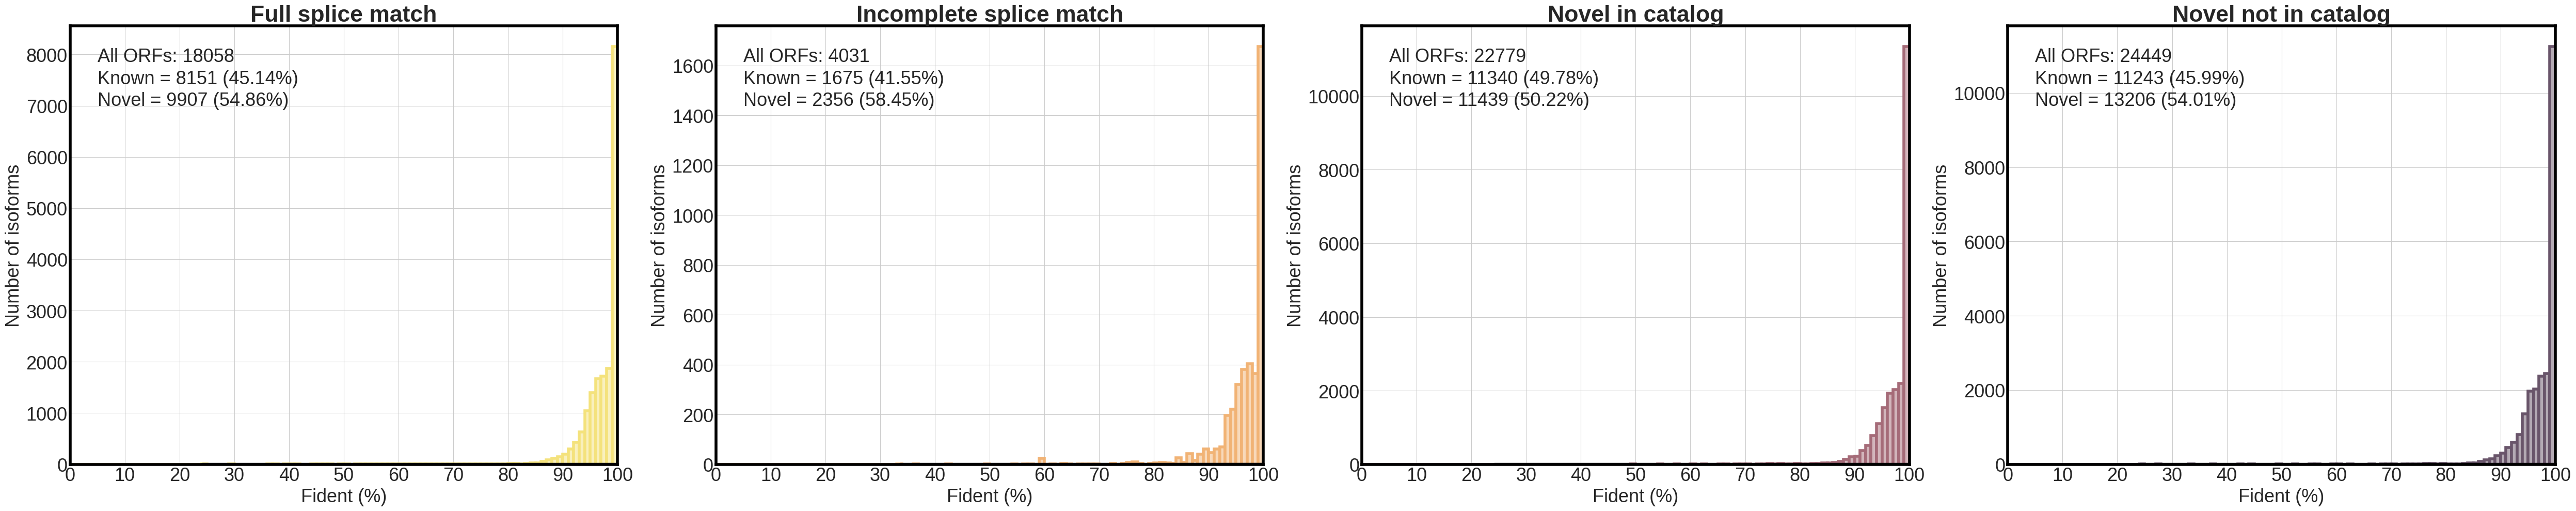

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# 读取 merged_results.outfmt6 文件
df = pd.read_csv('./filtering_transcriptome/merged_result.outfmt6', sep='\t')

def format_category(category):
    if pd.isna(category) or not isinstance(category, str):
        return category  # 如果是空值或非字符串，直接返回
    words = re.split('_|-', category)
    words[0] = words[0].capitalize()
    return ' '.join(words)

# 应用格式化函数
df['structural_category'] = df['structural_category'].apply(format_category)
df['fident'] = df['fident'] * 100  # 将fident从0-1范围转换为0-100

# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 定义要绘制的类别和对应的颜色
categories_to_plot = [
    'Full splice match',
    'Incomplete splice match',
    'Novel in catalog',
    'Novel not in catalog'
]

# 定义浅色和深色
dark_colors = ['#F4E27C', '#f1b375', '#a56b78','#69556a']  # 深色
light_colors = ['#f9f0bd', '#f8d9ba', '#d2b5bb', '#b4aab4']  # 浅色

# 创建1x4的子图
fig, axs = plt.subplots(1, 4, figsize=(50, 10), squeeze=False)

# 定义 bin 的范围
bins = np.arange(0, 101, 1)  # 0到100，步长为1

# 遍历选定的 structural categories
for i, category in enumerate(categories_to_plot):
    # 获取该类别的数据
    cat_data = df[df['structural_category'] == category]
   
    # 计算统计数据
    total_queries = len(cat_data)
    known_queries = len(cat_data[cat_data['fident'] >= 99])
    novel_queries = total_queries - known_queries
    known_percent = (known_queries / total_queries) * 100 if total_queries > 0 else 0
    novel_percent = (novel_queries / total_queries) * 100 if total_queries > 0 else 0
   
    # 创建直方图数据
    hist, _ = np.histogram(cat_data['fident'], bins=bins)
   
    # 绘制条形图
    axs[0, i].bar(bins[:-1], hist, width=1, color=light_colors[i],
                  edgecolor=dark_colors[i], align='edge', linewidth=4)
   
    # 在条形图上叠加一层密度曲线
    sns.kdeplot(data=cat_data['fident'], ax=axs[0, i],
                color='black', linewidth=4,
                cut=0, clip=(0, 100))
   
    # 设置标题和标签
    axs[0, i].set_title(f'{category}', fontsize=32, fontweight='bold')
    axs[0, i].set_xlabel('Fident (%)', fontsize=26)
    axs[0, i].set_ylabel('Number of isoforms', fontsize=26)
   
    # 设置x轴范围和刻度
    axs[0, i].set_xlim(0, 100)
    axs[0, i].set_xticks(range(0, 101, 10))
   
    # 调整刻度标签大小
    axs[0, i].tick_params(axis='both', which='major', labelsize=26)
   
    # 添加黑色边框
    for spine in axs[0, i].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(4)
   
    # 添加标签
    axs[0, i].text(0.05, 0.95, f'All ORFs: {total_queries}', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.90, f'Known = {known_queries} ({known_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.85, f'Novel = {novel_queries} ({novel_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')

# 调整子图之间的间距
plt.tight_layout()

# 保存图表
plt.savefig('selected_structural_category_distribution.png', dpi=500, bbox_inches='tight')
print("Selected structural category distribution plot saved as selected_structural_category_distribution.png")

# 显示图表(如果您在支持图形界面的环境中运行)
# plt.show()


### 检查这种过滤下来对我构建的网络的影响

In [159]:
import pandas as pd

def get_intersection(sqanti_file, bc_file):
    # 读取SQANTI过滤后的结果文件
    sqanti_df = pd.read_csv(sqanti_file, sep='\t')
    
    # 读取BC_key文件
    bc_df = pd.read_csv(bc_file, sep='\t')
    
    # 获取SQANTI文件中的isoform列
    sqanti_ids = set(sqanti_df['isoform_id'])
    
    # 获取BC_key文件中的第一列，并去掉以"AF-"开头的ID
    bc_ids = set(bc_df.iloc[:, 0].unique())

    
    # 输出去掉"AF-"开头ID后的BC文件ID数量
    print(f"all ids: {len(bc_df)}")
    print(f"Number of IDs in BC_key file after removing 'AF-' prefixed IDs: {len(bc_ids)}")
    
    # 计算交集
    intersection = sqanti_ids.intersection(bc_ids)
    
    # 输出结果
    print(f"Number of IDs in SQANTI file: {len(sqanti_ids)}")
    print(f"Number of IDs in the intersection: {len(intersection)}")
    
    return intersection

# 使用函数
intersection = get_intersection('./filtering_transcriptome/021.filtered.gff3_classification_merged_detection_rate.tsv', 'BC_key_column_tmscore_0.9_clean_v2.tsv')

# # 如果你想查看交集中的具体ID，可以取消下面的注释
# print("Intersection IDs:")
# for id in intersection:
#     print(id)

/tmp/ipykernel_1287118/441689801.py:31: DtypeWarning: Columns (1,2,5,6,7,14,15,16,19,24,28,29,36,38,40,42,43,45,46,50,51,52,53,54,55,57,58,63,66,73) have mixed types.Specify dtype option on import or set low_memory=False.
  intersection = get_intersection('./filtering_transcriptome/021.filtered.gff3_classification_merged_detection_rate.tsv', 'BC_key_column_tmscore_0.9_clean_v2.tsv')


all ids: 387117
Number of IDs in BC_key file after removing 'AF-' prefixed IDs: 48228
Number of IDs in SQANTI file: 106633
Number of IDs in the intersection: 44581


## 严格过滤用于做实验（以后再说，这样过滤也容易导致假阴性）

In [ ]:
import pandas as pd
import numpy as np

def filter_sqanti_results(input_file, output_file):
    # 读取SQANTI输出文件
    df = pd.read_csv(input_file, sep='\t')

    # 分离isoform_id以AF-开头的行，处理NaN值
    af_rows = df[df['isoform_id'].fillna('').str.startswith('AF-')]
    
    # 打印过滤前每个structural_category的数量，排除AF-开头的行
    print("Original structural_category counts (excluding AF-isoforms):")
    print(df[~df['isoform_id'].fillna('').str.startswith('AF-')]['structural_category'].value_counts())

    # 定义过滤函数
    def apply_filters(row):
        # 基本过滤条件：RTS_stage必须为False
        basic_filter = (row['RTS_stage'] == False)
        
        # 判断是否为canonical splice sites
        canonical = (row['all_canonical'] == 'canonical')
        
        # 读取覆盖度过滤：min_cov必须大于等于5
        coverage_filter = (row['min_cov'] >= 5)
        
        # detection rate
        detection = (row['sample_no'] >= 3)
        
        # 3'末端可靠性过滤：满足3个条件之一
        three_prime_filter = (
            (abs(row['diff_to_TTS']) <= 100) or
            (row['within_polyA_site'] == True)
        )
        # NMD detection
        predicted_NMD = row['predicted_NMD'] == False
        
        # 根据structural_category应用不同的过滤条件
        if row['structural_category'] == 'full-splice_match':
            # 对于 full-splice_match 不进行过滤，直接保留
            return True
        elif row['structural_category'] in ['novel_not_in_catalog']:
            return basic_filter and three_prime_filter and detection and canonical and coverage_filter
        elif row['structural_category'] in ['novel_in_catalog']:
            return basic_filter and three_prime_filter and detection and canonical and coverage_filter
        elif row['structural_category'] in ['incomplete-splice_match']:
            return basic_filter and three_prime_filter and detection and canonical and coverage_filter
        else:  # 其他类别 (genic, antisense, fusion, intergenic)
            return basic_filter and three_prime_filter and detection and canonical and coverage_filter
    
    # 对除isoform_id以AF-开头的行之外的所有行应用过滤条件
    df_filtered = df[~df['isoform_id'].fillna('').str.startswith('AF-')].copy()
    df_filtered = df_filtered[df_filtered.apply(apply_filters, axis=1)]

    # 合并保留的AF-开头的行和过滤后的其他行
    final_df = pd.concat([af_rows, df_filtered])

    # 保存过滤后的结果
    final_df.to_csv(output_file, sep='\t', index=False)

    # 打印过滤后的每个structural_category的数量，排除AF-开头的行
    print("\nFiltered structural_category counts (excluding AF-isoforms):")
    print(final_df[~final_df['isoform_id'].fillna('').str.startswith('AF-')]['structural_category'].value_counts())

    # 打印结果统计
    print(f"\nOriginal isoforms (excluding AF-isoforms): {len(df[~df['isoform_id'].fillna('').str.startswith('AF-')])}")
    print(f"Filtered isoforms (excluding AF-isoforms): {len(final_df[~final_df['isoform_id'].fillna('').str.startswith('AF-')])}")
    print(f"Percentage retained (excluding AF-isoforms): {len(final_df[~final_df['isoform_id'].fillna('').str.startswith('AF-')]) / len(df[~df['isoform_id'].fillna('').str.startswith('AF-')]) * 100:.2f}%")

# 使用示例
filter_sqanti_results('./020.brca_classifcation_sampeCount_loc_symbol_meanPSI_DR_deltaPSI_mane_drug_target_drug_FC_org_func_singleton.tsv', './filtering_transcriptome/022.very_strict_filtered.gff3_classification_merged_detection_rate.tsv')


/tmp/ipykernel_1287118/3242760234.py:68: DtypeWarning: Columns (1,2,5,6,7,14,15,16,19,24,28,29,36,38,40,42,43,45,46,50,51,52,53,54,55,57,58,63,65,66,73) have mixed types.Specify dtype option on import or set low_memory=False.
  filter_sqanti_results('./020.brca_classifcation_sampeCount_loc_symbol_meanPSI_DR_deltaPSI_mane_drug_target_drug_FC_org_func_singleton.tsv', './filtering_transcriptome/021.filtered.gff3_classification_merged_detection_rate.tsv')


Original structural_category counts (excluding AF-isoforms):
novel_not_in_catalog       32456
incomplete-splice_match    31494
novel_in_catalog           27272
full-splice_match          24176
intergenic                 10089
fusion                      2252
antisense                   1507
genic                         88
genic_intron                   1
Name: structural_category, dtype: int64

Filtered structural_category counts (excluding AF-isoforms):
full-splice_match          24176
incomplete-splice_match     9524
novel_in_catalog            8467
novel_not_in_catalog        1777
fusion                        53
antisense                      7
genic                          3
intergenic                     2
Name: structural_category, dtype: int64

Original isoforms (excluding AF-isoforms): 129337
Filtered isoforms (excluding AF-isoforms): 44009
Percentage retained (excluding AF-isoforms): 34.03%


In [145]:
import pandas as pd

def get_intersection(sqanti_file, bc_file):
    # 读取SQANTI过滤后的结果文件
    sqanti_df = pd.read_csv(sqanti_file, sep='\t')
    
    # 读取BC_key文件
    bc_df = pd.read_csv(bc_file, sep='\t')
    
    # 获取SQANTI文件中的isoform列
    sqanti_ids = set(sqanti_df['isoform'])
    
    # 获取BC_key文件中的第一列，并去掉以"AF-"开头的ID
    bc_ids = set(bc_df.iloc[:, 0][~bc_df.iloc[:, 0].str.startswith('AF-')])
    
    
    # 输出去掉"AF-"开头ID后的BC文件ID数量
    print(f"all ids: {len(bc_df)}")
    print(f"Number of IDs in BC_key file after removing 'AF-' prefixed IDs: {len(bc_ids)}")
    
    # 计算交集
    intersection = sqanti_ids.intersection(bc_ids)
    
    # 输出结果
    print(f"Number of IDs in SQANTI file: {len(sqanti_ids)}")
    print(f"Number of IDs in the intersection: {len(intersection)}")
    
    return intersection

# 使用函数
intersection = get_intersection('./filtering_transcriptome/022.very_strict_filtered.gff3_classification_merged_detection_rate.tsv', 'BC_key_column_tmscore_0.9_clean_v2.tsv')

# # 如果你想查看交集中的具体ID，可以取消下面的注释
# print("Intersection IDs:")
# for id in intersection:
#     print(id)

all ids: 387117
Number of IDs in BC_key file after removing 'AF-' prefixed IDs: 32589
Number of IDs in SQANTI file: 63442
Number of IDs in the intersection: 20810


In [80]:
import pandas as pd

# 打开文件并提取完整的 ORF IDs 列表
with open('../../../transcripts_brca_1miC_1miS.fa.transdecoder.pep', 'r') as file:
    complete_orf_ids = []
    for line in file:
        if line.startswith('>') and 'ORF type:complete' in line:
            fasta_id = line.split()[0][1:]  # 去掉 ">" 并提取 ID 部分
            complete_orf_ids.append(fasta_id)

# 检查是否成功提取 ORF IDs
if not complete_orf_ids:
    print("Error: No complete ORF IDs were found.")
    exit()

# 读取 result2.outfmt6 文件
try:
    result_df = pd.read_csv('./result2.outfmt6', sep='\t', header=None)
except FileNotFoundError:
    print("Error: result2.outfmt6 file not found.")
    exit()

# 添加列名，标准BLAST格式为outfmt 6
result_df.columns = ['query', 'target', 'fident', 'alnlen', 'mismatch', 'gapopen',
                     'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bitscore']

# 确保 query 列的所有值都是字符串
result_df['query'] = result_df['query'].astype(str)

# 过滤出 query 在 complete_orf_ids 列表中的行
filtered_result_df = result_df[result_df['query'].isin(complete_orf_ids)]

# 提取 query 列的最后一个 '.' 之前的内容
filtered_result_df['query'] = filtered_result_df['query'].apply(lambda x: x.rsplit('.', 1)[0])

# 将 fident 列转换为浮点数，忽略非数值内容
filtered_result_df['fident'] = pd.to_numeric(filtered_result_df['fident'], errors='coerce')

# 过滤掉无法转换为浮点数的行
filtered_result_df = filtered_result_df.dropna(subset=['fident'])

# 按 query 和 fident 排序，保留 fident 最高的行
filtered_result_df = filtered_result_df.sort_values('fident', ascending=False).drop_duplicates('query', keep='first')

# 读取 PacBio 分类文件
try:
    gff3_df = pd.read_csv('./filtering_transcriptome/021.filtered.gff3_classification_merged_detection_rate.tsv', sep='\t')
except FileNotFoundError:
    print("Error: PacBio classification file not found.")
    exit()

# 确保 isoform 列唯一，以防止意外重复
gff3_df = gff3_df.drop_duplicates(subset=['isoform'])

# 按 isoform 和 query 列进行合并，以 gff3_df 为主
merged_df = gff3_df[['isoform', 'structural_category', 'predicted_NMD', 'detection_rate']].merge(
    filtered_result_df, left_on='isoform', right_on='query', how='left')

# 只保留需要的列
final_df = merged_df[['isoform', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD', 'detection_rate']]

# 打印结果
print(final_df)

# 保存合并后的结果到新文件，并添加列名
output_file = 'merged_result.outfmt6'
final_df.to_csv(output_file, sep='\t', index=False,
                header=['query', 'target', 'fident', 'gapopen', 'evalue', 'structural_category', 'predicted_NMD', 'detection_rate'])

print(f"Merged results saved to {output_file}")

/master/jiang_tao/0.software/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_1287118/36421816.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result_df['query'] = filtered_result_df['query'].apply(lambda x: x.rsplit('.', 1)[0])
/tmp/ipykernel_1287118/36421816.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

                  isoform      target  fident gapopen evalue  \
0      ENST00000054666.11  A0A2R8ZGK1   0.917       0    0.0   
1       ENST00000196061.5  A0A2R9B150   0.996       0    0.0   
2      ENST00000234590.10      A4QMW8   0.974       0    0.0   
3       ENST00000234875.9      Q8WYP0   0.963       0    0.0   
4      ENST00000235329.10      B3KM52   0.960       0    0.0   
...                   ...         ...     ...     ...    ...   
64388     TALONT000261197      Q05DA9   0.953       0    0.0   
64389     TALONT000261226      Q02040   0.863       0    0.0   
64390     TALONT000261230      Q05DA9   0.955       0    0.0   
64391     TALONT000261243         NaN     NaN     NaN    NaN   
64392     TALONT000261505         NaN     NaN     NaN    NaN   

           structural_category predicted_NMD  detection_rate  
0            full-splice_match         False        0.997758  
1            full-splice_match         False        0.995516  
2            full-splice_match         Fal

In [90]:
import pandas as pd

# 读取文件
df = pd.read_csv('merged_result.outfmt6', sep='\t')

# 提取structural_category为'full-splice_match'且predicted_NMD为False的行
filtered_df = df[(df['structural_category'] == 'full-splice_match') & (df['predicted_NMD'] == False) & (df['detection_rate'] >= 0.2)]

# 计算fident >= 0.99的行数和fident < 0.99的行数
fident_ge_099 = filtered_df[filtered_df['fident'] >= 0.99].shape[0]
fident_lt_099 = filtered_df[filtered_df['fident'] < 0.99].shape[0]

# 计算比率
total = fident_ge_099 + fident_lt_099
ratio_ge_099 = fident_ge_099 / total if total > 0 else 0
ratio_lt_099 = fident_lt_099 / total if total > 0 else 0

# 输出结果
print(f"fident >= 0.99: {fident_ge_099}, fident < 0.99: {fident_lt_099}")
print(f"Ratio of fident >= 0.99: {ratio_ge_099:.2f}, fident < 0.99: {ratio_lt_099:.2f}")


fident >= 0.99: 6629, fident < 0.99: 7891
Ratio of fident >= 0.99: 0.46, fident < 0.99: 0.54


In [89]:
import pandas as pd

def analyze_fident_distribution(input_file):
    # 读取数据文件
    df = pd.read_csv(input_file, sep='\t')
    
    # 确保 fident 列是数值型
    df['fident'] = pd.to_numeric(df['fident'], errors='coerce')
    
    # 计算 fident >= 0.99 和 fident < 0.99 的布尔值
    df['fident_ge_099'] = df['fident'] >= 0.99
    df['fident_lt_099'] = df['fident'] < 0.99
    
    # 统计不同 structural_category 的数量
    category_stats = df.groupby('structural_category').agg({
        'fident_ge_099': 'sum',
        'fident_lt_099': 'sum'
    }).reset_index()
    
    # 重命名列以便于阅读
    category_stats.rename(columns={
        'fident_ge_099': 'count_fident_ge_0.99',
        'fident_lt_099': 'count_fident_lt_0.99'
    }, inplace=True)
    
    # 统计每个group的总数
    category_stats['total'] = category_stats['count_fident_ge_0.99'] + category_stats['count_fident_lt_0.99']
    
    # 计算所有行的总和
    total_stats = pd.DataFrame(category_stats[['count_fident_ge_0.99', 'count_fident_lt_0.99']].sum()).T
    total_stats['structural_category'] = 'Total'
    total_stats['total'] = total_stats['count_fident_ge_0.99'] + total_stats['count_fident_lt_0.99']
    
    # 将总和添加到结果中
    final_stats = pd.concat([category_stats, total_stats], ignore_index=True)

    # 输出结果
    print(final_stats)

# 使用示例
analyze_fident_distribution('merged_result.outfmt6')


       structural_category  count_fident_ge_0.99  count_fident_lt_0.99  total
0                antisense                     6                    21     27
1        full-splice_match                  7743                  9413  17156
2                   fusion                   123                   128    251
3                    genic                     3                     8     11
4  incomplete-splice_match                  3756                  5766   9522
5               intergenic                     2                    12     14
6         novel_in_catalog                  3965                  4356   8321
7     novel_not_in_catalog                  2602                  3159   5761
8                    Total                 18200                 22863  41063


/tmp/ipykernel_1287118/1152615898.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Selected structural category distribution plot saved as selected_structural_category_distribution.png


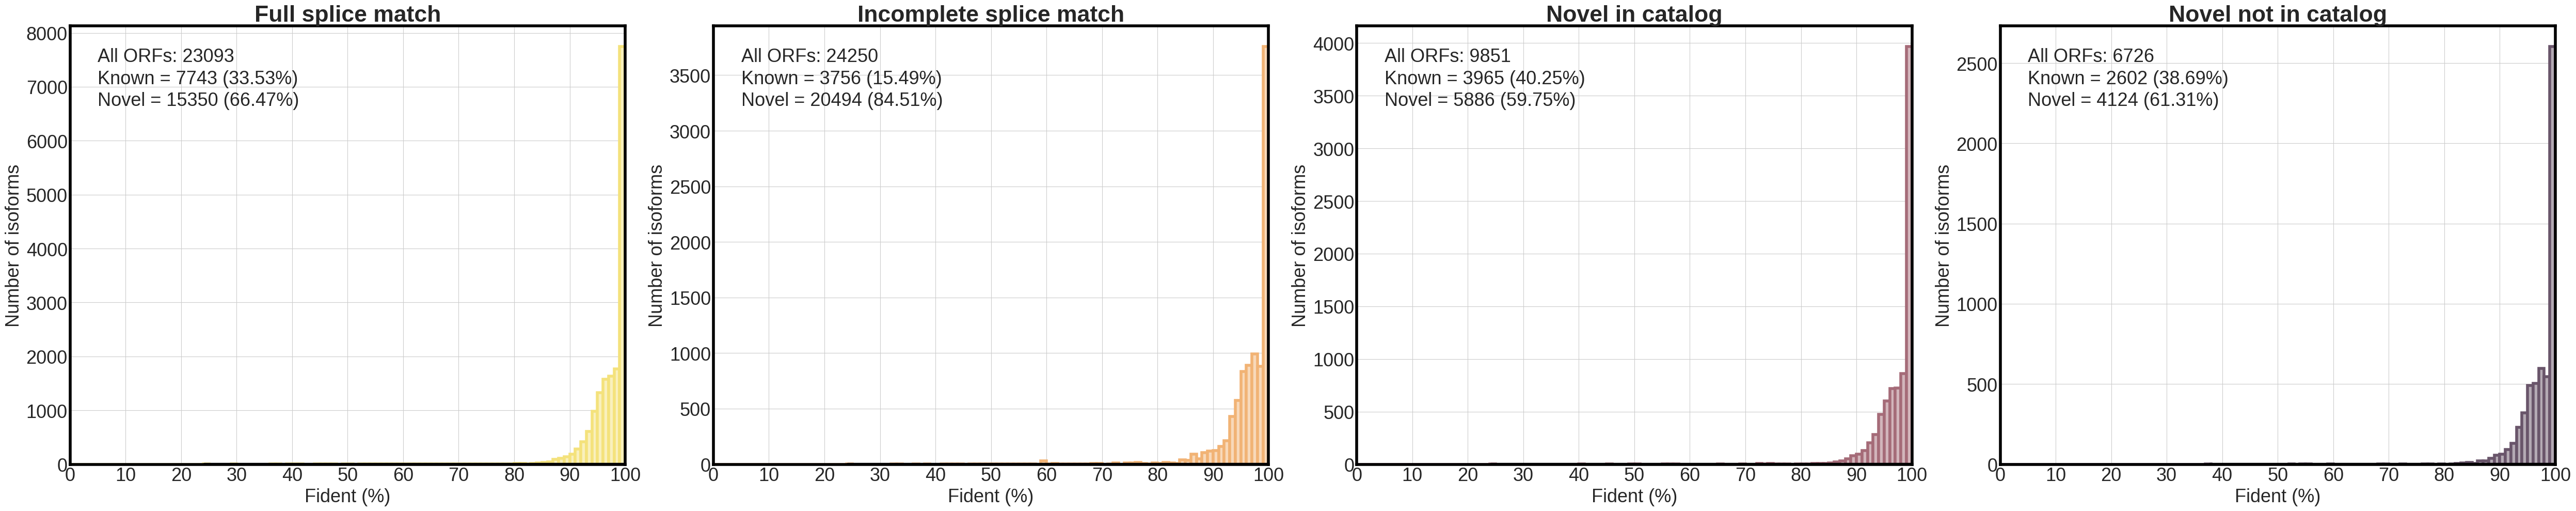

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# 读取 merged_results.outfmt6 文件
df = pd.read_csv('merged_result.outfmt6', sep='\t')

# 定义函数来格式化 structural_category
def format_category(category):
    words = re.split('_|-', category)
    words[0] = words[0].capitalize()
    return ' '.join(words)

# 应用格式化函数
df['structural_category'] = df['structural_category'].apply(format_category)
df['fident'] = df['fident'] * 100  # 将fident从0-1范围转换为0-100

# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 定义要绘制的类别和对应的颜色
categories_to_plot = [
    'Full splice match',
    'Incomplete splice match',
    'Novel in catalog',
    'Novel not in catalog'
]

# 定义浅色和深色
dark_colors = ['#F4E27C', '#f1b375', '#a56b78','#69556a']  # 深色
light_colors = ['#f9f0bd', '#f8d9ba', '#d2b5bb', '#b4aab4']  # 浅色

# 创建1x4的子图
fig, axs = plt.subplots(1, 4, figsize=(50, 10), squeeze=False)

# 定义 bin 的范围
bins = np.arange(0, 101, 1)  # 0到100，步长为1

# 遍历选定的 structural categories
for i, category in enumerate(categories_to_plot):
    # 获取该类别的数据
    cat_data = df[df['structural_category'] == category]
   
    # 计算统计数据
    total_queries = len(cat_data)
    known_queries = len(cat_data[cat_data['fident'] >= 99])
    novel_queries = total_queries - known_queries
    known_percent = (known_queries / total_queries) * 100 if total_queries > 0 else 0
    novel_percent = (novel_queries / total_queries) * 100 if total_queries > 0 else 0
   
    # 创建直方图数据
    hist, _ = np.histogram(cat_data['fident'], bins=bins)
   
    # 绘制条形图
    axs[0, i].bar(bins[:-1], hist, width=1, color=light_colors[i],
                  edgecolor=dark_colors[i], align='edge', linewidth=4)
   
    # 在条形图上叠加一层密度曲线
    sns.kdeplot(data=cat_data['fident'], ax=axs[0, i],
                color='black', linewidth=4,
                cut=0, clip=(0, 100))
   
    # 设置标题和标签
    axs[0, i].set_title(f'{category}', fontsize=32, fontweight='bold')
    axs[0, i].set_xlabel('Fident (%)', fontsize=26)
    axs[0, i].set_ylabel('Number of isoforms', fontsize=26)
   
    # 设置x轴范围和刻度
    axs[0, i].set_xlim(0, 100)
    axs[0, i].set_xticks(range(0, 101, 10))
   
    # 调整刻度标签大小
    axs[0, i].tick_params(axis='both', which='major', labelsize=26)
   
    # 添加黑色边框
    for spine in axs[0, i].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(4)
   
    # 添加标签
    axs[0, i].text(0.05, 0.95, f'All ORFs: {total_queries}', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.90, f'Known = {known_queries} ({known_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')
    axs[0, i].text(0.05, 0.85, f'Novel = {novel_queries} ({novel_percent:.2f}%)', transform=axs[0, i].transAxes, fontsize=26, va='top')

# 调整子图之间的间距
plt.tight_layout()

# 保存图表
plt.savefig('selected_structural_category_distribution.png', dpi=500, bbox_inches='tight')
print("Selected structural category distribution plot saved as selected_structural_category_distribution.png")

# 显示图表(如果您在支持图形界面的环境中运行)
# plt.show()
